##### Course Source
       https://www.kaggle.com/learn/machine-learning-explainability

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import eli5
from eli5.sklearn import PermutationImportance
import shap
#from pdpbox import pdp, get_dataset, info_plots

# Model

##### load data

In [2]:
data = pd.read_csv("FIFA 2018 Statistics.csv")

In [3]:
data.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


##### check the string (whether there are mistakes)

In [4]:
print("String in 'Man of the Match' colume: ")
print(data['Man of the Match'].unique())

String in 'Man of the Match' colume: 
['Yes' 'No']


##### set Y and convert it in to binary

In [5]:
y = np.array(data['Man of the Match'] == 'Yes')

##### selct X where data types are int64 or float64

In [6]:
x = data.select_dtypes(include = ['int64'])

##### check NA

In [7]:
print("NA Column names: ")
print(x.isnull().sum()[x.isnull().sum() != 0])

NA Column names: 
Series([], dtype: int64)


##### Slipt dataset and build model

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

# Permutation

## How Permutation works
Steps:

1. Get a trained model.

2. Shuffle the values in a single column, make predictions using the resulting dataset. 
Use these predictions and the true target values to calculate how much the loss function 
suffered from shuffling. That performance deterioration measures the importance of the 
variable you just shuffled.

3. Return the data to the original order (undoing the shuffle from step 2). 
Now repeat step 2 with the next column in the dataset, 
until you have calculated the importance of each column.

In [9]:
import eli5
from eli5.sklearn import PermutationImportance

## Feature Importance

##### Whole model feature importance

In [10]:
eli5.show_weights(model, feature_names = list(x_train.columns))

Weight,Feature
0.1907 ± 0.2597,Goal Scored
0.0941 ± 0.1730,Attempts
0.0765 ± 0.1452,On-Target
0.0743 ± 0.1358,Ball Possession %
0.0702 ± 0.1310,Distance Covered (Kms)
0.0596 ± 0.1172,Free Kicks
0.0591 ± 0.1167,Passes
0.0588 ± 0.1407,Pass Accuracy %
0.0536 ± 0.1064,Corners
0.0524 ± 0.1220,Blocked


##### Feature importance for a sample

In [11]:
x_sample = np.array(x_train.iloc[0])
eli5.show_prediction(model, x_sample, feature_names = x_train.columns.tolist())

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


## Perputation Importance

In [12]:
perm = PermutationImportance(model, random_state=1)
perm.fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_train.columns.tolist())

Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


 ##### Interpretation
1. The values towards the top are the most important features, and those towards the bottom matter least.

2. The first number in each row shows how much model performance decreased with a random shuffling.
The number after the ± measures how performance varied from one-reshuffling to the next.

3. You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example,because there is more room for luck/chance.

# Partial Plot

## How to Interprete the Outcome

- While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.


- If you are familiar with linear or logistic regression models, partial dependence plots can be interpreted similarly to the coefficients in those models. Though, partial dependence plots on sophisticated models can capture more complex patterns than coefficients from simple models.


- We will use the fitted model to predict our outcome (probability their player won "man of the match"). But we repeatedly alter the value for one variable to make a series of predictions. We could predict the outcome if the team had the ball only 40% of the time. We then predict with them having the ball 50% of the time. Then predict again for 60%. And so on. We trace out predicted outcomes (on the vertical axis) as we move from small values of ball possession to large values (on the horizontal axis).


- In this description, we used only a single row of data. Interactions between features may cause the plot for a single row to be atypical. So, we repeat that mental experiment with multiple rows from the original dataset, and we plot the average predicted outcome on the vertical axis.

In [13]:
from sklearn.inspection import plot_partial_dependence

## 1D

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


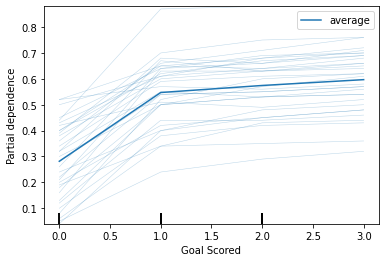

In [14]:
plot_partial_dependence(model,x_test, [0], kind='both')  

 ##### Interpretation
1. The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
2. A blue shaded area indicates level of confidence.

From this particular graph, we see that scoring a goal substantially increases your chances of winning "Man of The Match." But extra goals beyond that appear to have little impact on predictions.

## 2D

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


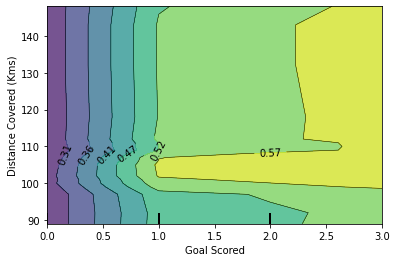

In [15]:
plot_partial_dependence(model,x_test, [[0,12]])  

 ##### Interpretation
This graph shows predictions for any combination of Goals Scored and Distance covered. For example, we see the highest predictions when a team scores at least 1 goal and they run a total distance close to 100km. If they score 0 goals, distance covered doesn't matter. 

# SHAP

## Introduction
- SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature.
- SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.
- SHAP values do this in a way that guarantees a nice property. Specifically, you decompose a prediction with the following equation:
            sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values

##### randomly choose one row to predict

In [16]:
row_to_show = 5
data_for_prediction = x_test.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
model.predict_proba(data_for_prediction_array)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0.29, 0.71]])

In [17]:
import shap

## Shap Value - Single Sample

In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

##### Interpretation
- We predicted 0.71, whereas the base_value is 0.5013. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from Goal Scored being 2. Though the ball possession value has a meaningful effect decreasing the prediction.


- If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.


- If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in shap.TreeExplainer(my_model). But the SHAP package has explainers for every type of model.
    - shap.DeepExplainer works with Deep Learning models.
    - shap.KernelExplainer works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.
    
    
##### Code tips
- When plotting, we call shap_values[1]. For classification problems, there is a separate array of SHAP values for each possible outcome. In this case, we index in to get the SHAP values for the prediction of "True".
- Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small. But you'll want to be careful when running these to plot with reasonably sized datasets. The exception is when using an xgboost model, which SHAP has some optimizations for and which is thus much faster.

## Shape Value - Model

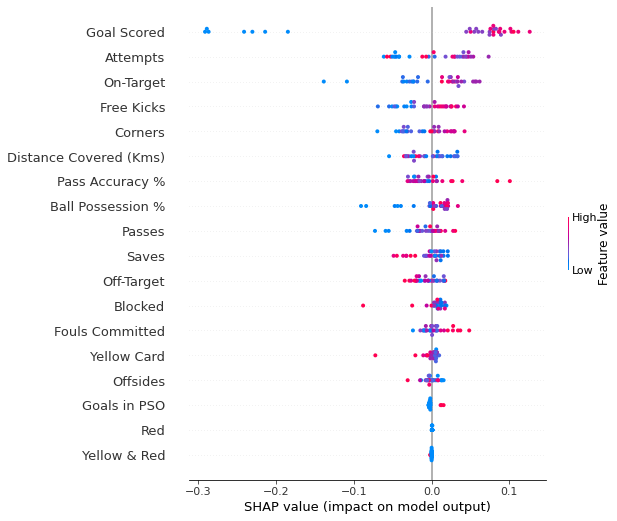

In [19]:
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values[1], x_test)

- SHAP summary plots give us a birds-eye view of feature importance and what is driving it.

- This plot is made of many dots. Each dot has three characteristics:
    - Vertical location shows what feature it is depicting
    - Color shows whether that feature was high or low for that row of the dataset
    - Horizontal location shows whether the effect of that value caused a higher or lower prediction.
- For example, the point in the upper left was for a team that scored few goals, reducing the prediction by 0.25.

- Some things you should be able to easily pick out:
    - The model ignored the Red and Yellow & Red features.
    - Usually Yellow Card doesn't affect the prediction, but there is an extreme case where a high value caused a much lower prediction.
    - High values of Goal scored caused higher predictions, and low values caused low predictions

## SHAP Value - Dependence Feature Contribution

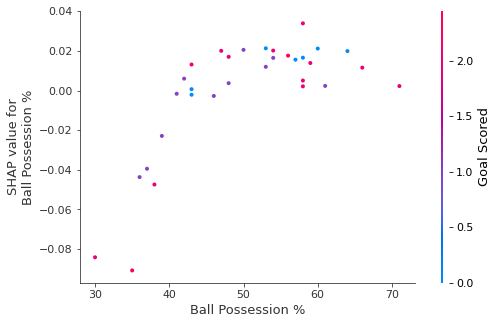

In [20]:
shap.dependence_plot('Ball Possession %', shap_values[1], x_test, interaction_index="Goal Scored")
# If you don't supply an argument for interaction_index, 
# Shapley uses some logic to pick one that may be interesting.

##### interpretation
- start by focusing on the shape, and we'll come back to color in a minute. Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The fact this slopes upward says that the more you possess the ball, the higher the model's prediction is for winning the Man of the Match award.


- The spread suggests that other features must interact with Ball Possession %. For example, here we have highlighted two points with similar ball possession values. That value caused one prediction to increase, and it caused the other prediction to decrease.


- For comparison, a simple linear regression would produce plots that are perfect lines, without this spread.This suggests we delve into the interactions, and the plots include color coding to help do that. While the primary trend is upward, you can visually inspect whether that varies by dot color.


- These two points stand out spatially as being far away from the upward trend. They are both colored purple, indicating the team scored one goal. You can interpret this to say In general, having the ball increases a team's chance of having their player win the award. But if they only score one goal, that trend reverses and the award judges may penalize them for having the ball so much if they score that little.


- Outside of those few outliers, the interaction indicated by color isn't very dramatic here. But sometimes it will jump out at you.